<h1>TASK 3. SAMPLING OF MULTIVARIATE RANDOM VARIABLES</h1>

<a name='000'></a>

<h2>Content</h2>

<ul>
    <ol type='1'>
    <li><a href='#001'>Substantiation of Chosen Sampling</a></li>
    <li><a href='#002'>Sampling of Chosen Target Variables Using Univariate Parametric Distributions with 2 Different Sampling Methods</a></li>
    <li><a href='#003'>Estimation of Relations Between Predictors and Chosen Target Variables</a></li>
    <li><a href='#004'>Bayesian Network. Part I</a></li>
    <li><a href='#005'>Bayesian Network. Part II</a></li>
    <li><a href='#006'>Quality Analysis</a></li>
    </ol>
</ul>

<h2>0. Environment Setup</h2>

<a href='#000'>Back</a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import scipy.stats
import warnings

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from pgmpy.estimators import HillClimbSearch, TreeSearch, K2Score, BicScore
from pgmpy.models import BayesianModel
from pgmpy.sampling import BayesianModelSampling

In [2]:
warnings.filterwarnings(action='ignore')

<a name='001'></a>

<h2>1. Substantiation of Chosen Sampling</h2>

<a href='#000'>Back</a>

Dataset name: Heart Disease Data Set

Dataset source: https://www.kaggle.com/ronitf/heart-disease-uci/version/1

Dataset content:
- age of patient
- sex of patient
- chest pain type
- resting blood pressure
- serum cholestoral
- fasting blood sugar
- resting electrocardiographic results
- maximum heart rate achieved
- exercise induced angina
- ST depression induced by exercise relative to rest
- slope of the peak exercise ST segment
- number of major vessels colored by flourosopy
- thal

In [3]:
df = pd.read_csv('data/data.csv')

In [4]:
df.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [6]:
df = df[['age', 'sex', 'cp', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca', 'target', 'slope']]

q75, q25 = np.percentile(df['age'], [75, 25])
interval = q75 - q25
min_dist = q25 - (1.5 * interval)
max_dist = q75 + (1.5 * interval)
df.loc[(df['age'] < min_dist) | (df['age'] > max_dist), ('age')] = np.nan

q75, q25 = np.percentile(df['trestbps'], [75, 25])
interval = q75 - q25
min_dist = q25 - (1.5 * interval)
max_dist = q75 + (1.5 * interval)
df.loc[(df['trestbps'] < min_dist) | (df['trestbps'] > max_dist), ('trestbps')] = np.nan

q75, q25 = np.percentile(df['chol'], [75, 25])
interval = q75 - q25
min_dist = q25 - (1.5 * interval)
max_dist = q75 + (1.5 * interval)
df.loc[(df['chol'] < min_dist) | (df['chol'] > max_dist), ('chol')] = np.nan

q75, q25 = np.percentile(df['thalach'], [75, 25])
interval = q75 - q25
min_dist = q25 - (1.5 * interval)
max_dist = q75 + (1.5 * interval)
df.loc[(df['thalach'] < min_dist) | (df['thalach'] > max_dist), ('thalach')] = np.nan

q75, q25 = np.percentile(df['oldpeak'], [75, 25])
interval = q75 - q25
min_dist = q25 - (1.5 * interval)
max_dist = q75 + (1.5 * interval)
df.loc[(df['oldpeak'] < min_dist) | (df['oldpeak'] > max_dist), ('oldpeak')] = np.nan

df.dropna(inplace=True)

In [7]:
df.head(10)

,age,sex,cp,trestbps,chol,thalach,oldpeak,ca,target,slope
0,63.0,1,3,145.0,233.0,150.0,2.3,0,1,0
1,37.0,1,2,130.0,250.0,187.0,3.5,0,1,0
2,41.0,0,1,130.0,204.0,172.0,1.4,0,1,2
3,56.0,1,1,120.0,236.0,178.0,0.8,0,1,2
4,57.0,0,0,120.0,354.0,163.0,0.6,0,1,2
5,57.0,1,0,140.0,192.0,148.0,0.4,0,1,1
6,56.0,0,1,140.0,294.0,153.0,1.3,0,1,1
7,44.0,1,1,120.0,263.0,173.0,0.0,0,1,2
9,57.0,1,2,150.0,168.0,174.0,1.6,0,1,2
10,54.0,1,0,140.0,239.0,160.0,1.2,0,1,2


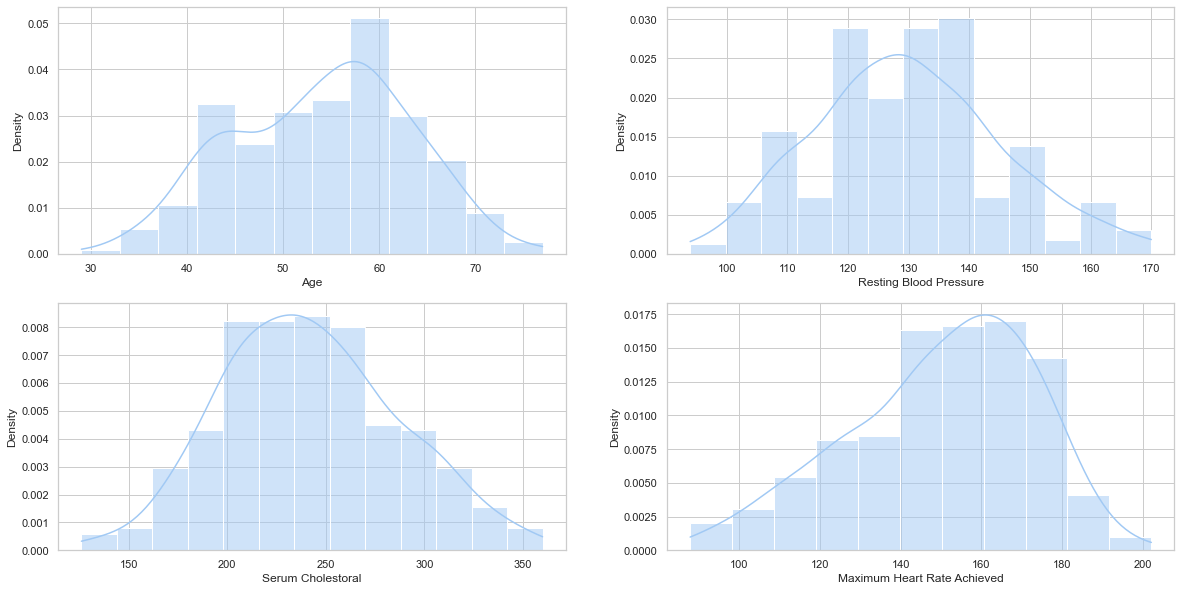

In [9]:
figure, ax = plt.subplots(2, 2, figsize=(20, 10))
sns.set_theme(style='whitegrid', palette='pastel')

age = sns.histplot(df.age, ax=ax[0, 0], kde=True, stat='density')
age.set(xlabel='Age')

trestbps = sns.histplot(df.trestbps, ax=ax[0, 1], kde=True, stat='density')
trestbps.set(xlabel='Resting Blood Pressure')

chol = sns.histplot(df.chol, ax=ax[1, 0], kde=True, stat='density')
chol.set(xlabel='Serum Cholestoral')

thalach = sns.histplot(df.thalach, ax=ax[1, 1], kde=True, stat='density')
thalach.set(xlabel='Maximum Heart Rate Achieved')

plt.show()

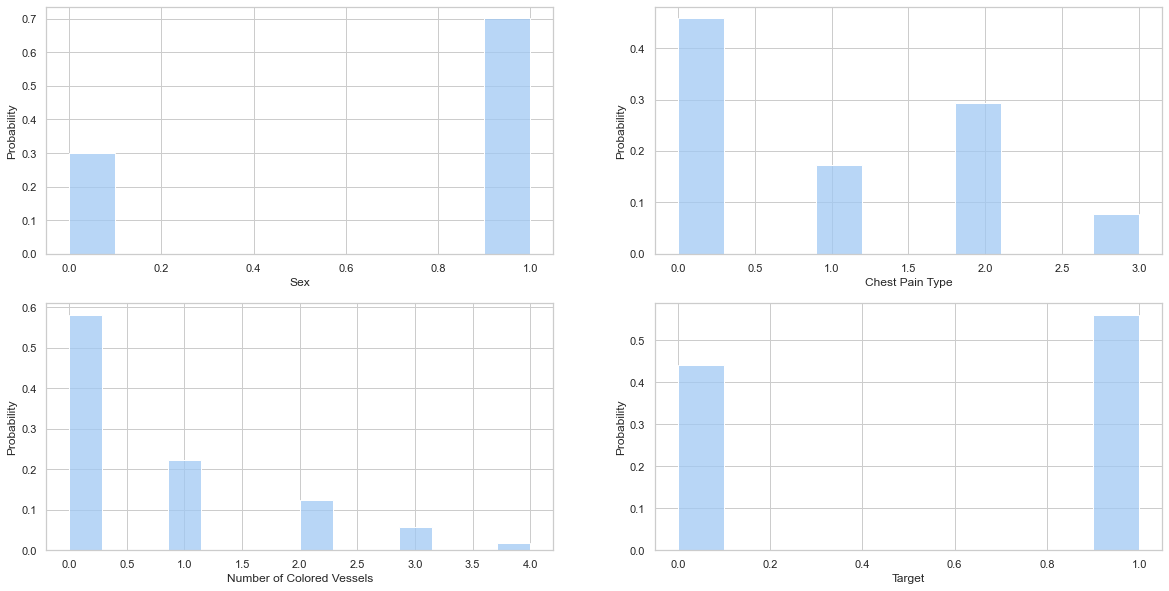

In [10]:
figure, ax = plt.subplots(2, 2, figsize=(20, 10))
sns.set_theme(style='whitegrid', palette='pastel')

sex = sns.histplot(df.sex, ax=ax[0, 0], kde=False, stat='probability')
sex.set(xlabel='Sex')

cp = sns.histplot(df.cp, ax=ax[0, 1], kde=False, stat='probability')
cp.set(xlabel='Chest Pain Type')

ca = sns.histplot(df.ca, ax=ax[1, 0], kde=False, stat='probability')
ca.set(xlabel='Number of Colored Vessels')

target = sns.histplot(df.target, ax=ax[1, 1], kde=False, stat='probability')
target.set(xlabel='Target')

plt.show()

<a name='002'></a>

<h2>2. Sampling of Chosen Target Variables Using Univariate Parametric Distributions with 2 Different Sampling Methods</h2>

<a href='#000'>Back</a>

In [11]:
def inverse_transform_sampling(array, distribution):
    args = distribution.fit(array)
    print('Distribution', type(distribution).__name__, 'arguments:', args)
    data = np.random.uniform(size=len(array))
    sample = distribution(*args)
    sample= sample.ppf(data)
    return sample

def custom_sampling(array, distribution):
    args = distribution.fit(array)
    sample = distribution.rvs(*args, size=len(array))
    return sample

def return_cdf(array):
    bins, x = np.histogram(array, bins=100)
    probas = bins / sum(bins)
    y = np.cumsum(probas)
    return x[:100], y[:100]

Age
Distribution beta_gen arguments: (4.940413099948174, 4.278601668214394, 22.644613074505607, 58.47091392664574)
Resting Blood Pressure
Distribution gamma_gen arguments: (39.286393460756884, 33.58895678820214, 2.4518161450330314)
Serum Cholestoral
Distribution norm_gen arguments: (242.07746478873239, 44.67497234622629)
Maximum Heart Rate Achieved
Distribution beta_gen arguments: (13.571711062912218, 4.8255388890316855, -16.04671820888172, 225.11777499056342)


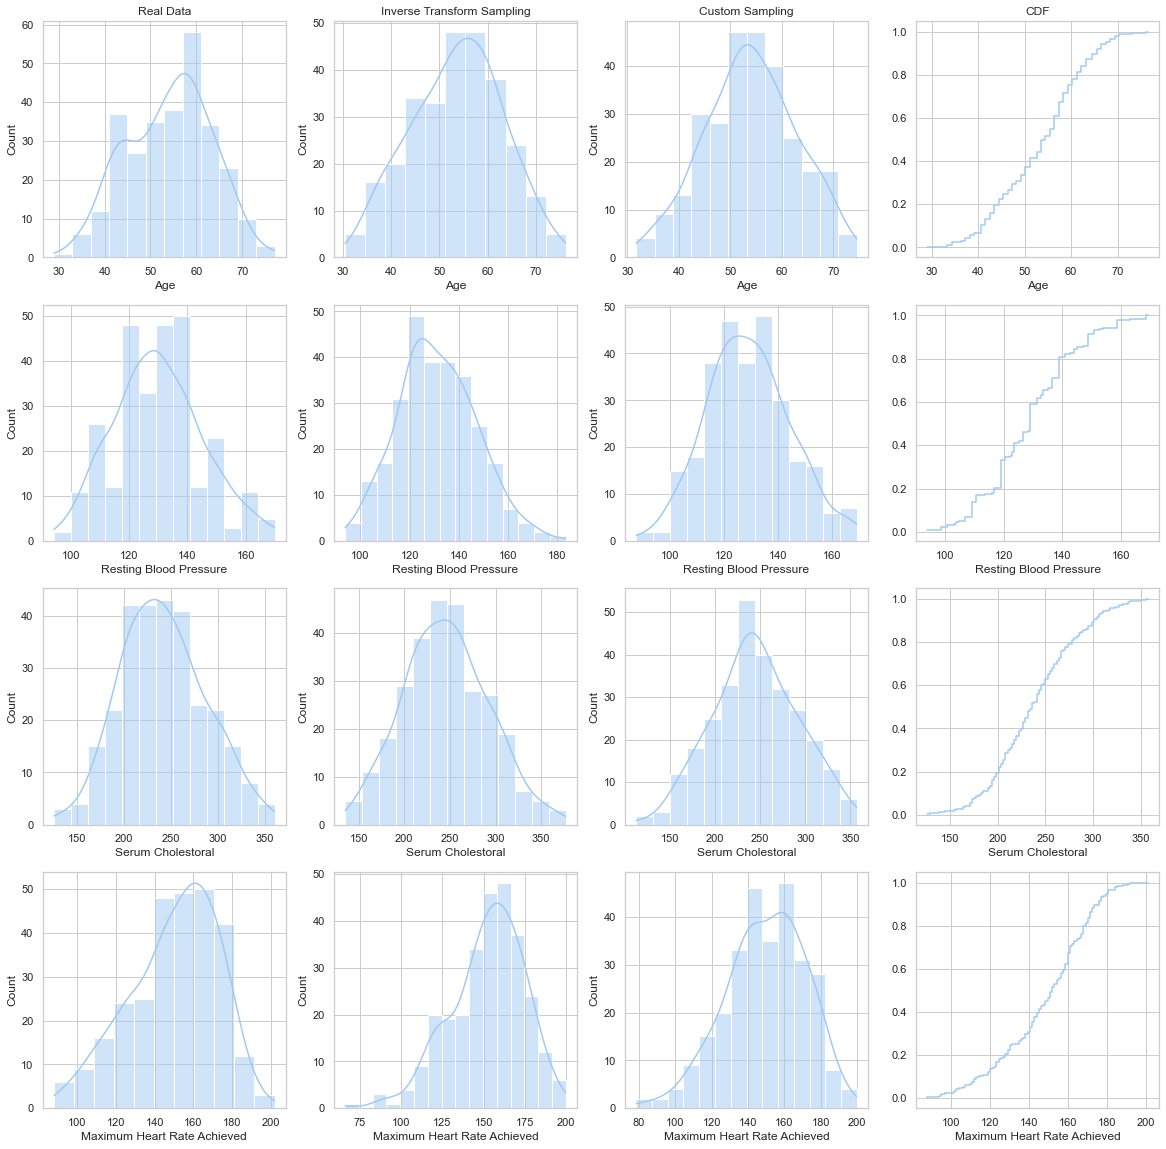

In [12]:
figure, ax = plt.subplots(4, 4, figsize=(20, 20))
sns.set_theme(style='whitegrid', palette='pastel')

print('Age')
sns.histplot(df.age, ax=ax[0, 0], kde=True)
sns.histplot(inverse_transform_sampling(df.age, distribution=scipy.stats.beta), ax=ax[0, 1], kde=True)
sns.histplot(custom_sampling(df.age, distribution=scipy.stats.beta), ax=ax[0, 2], kde=True)
sns.lineplot(return_cdf(df.age)[0], return_cdf(df.age)[1], ax=ax[0, 3], drawstyle='steps-pre')

print('Resting Blood Pressure')
sns.histplot(df.trestbps, ax=ax[1, 0], kde=True)
sns.histplot(inverse_transform_sampling(df.trestbps, distribution=scipy.stats.gamma), ax=ax[1, 1], kde=True)
sns.histplot(custom_sampling(df.trestbps, distribution=scipy.stats.gamma), ax=ax[1, 2], kde=True)
sns.lineplot(return_cdf(df.trestbps)[0], return_cdf(df.trestbps)[1], ax=ax[1, 3], drawstyle='steps-pre')

print('Serum Cholestoral')
sns.histplot(df.chol, ax=ax[2, 0], kde=True)
sns.histplot(inverse_transform_sampling(df.chol, distribution=scipy.stats.norm), ax=ax[2, 1], kde=True)
sns.histplot(custom_sampling(df.chol, distribution=scipy.stats.norm), ax=ax[2, 2], kde=True)
sns.lineplot(return_cdf(df.chol)[0], return_cdf(df.chol)[1], ax=ax[2, 3], drawstyle='steps-pre')

print('Maximum Heart Rate Achieved')
sns.histplot(df.thalach, ax=ax[3, 0], kde=True)
sns.histplot(inverse_transform_sampling(df.thalach, distribution=scipy.stats.beta), ax=ax[3, 1], kde=True)
sns.histplot(custom_sampling(df.thalach, distribution=scipy.stats.beta), ax=ax[3, 2], kde=True)
sns.lineplot(return_cdf(df.thalach)[0], return_cdf(df.thalach)[1], ax=ax[3, 3], drawstyle='steps-pre')

ax[0, 0].set_title('Real Data')
ax[0, 1].set_title('Inverse Transform Sampling')
ax[0, 2].set_title('Custom Sampling')
ax[0, 3].set_title('CDF')

ax[0, 0].set(xlabel='Age')
ax[0, 1].set(xlabel='Age')
ax[0, 2].set(xlabel='Age')
ax[0, 3].set(xlabel='Age')
ax[1, 0].set(xlabel='Resting Blood Pressure')
ax[1, 1].set(xlabel='Resting Blood Pressure')
ax[1, 2].set(xlabel='Resting Blood Pressure')
ax[1, 3].set(xlabel='Resting Blood Pressure')
ax[2, 0].set(xlabel='Serum Cholestoral')
ax[2, 1].set(xlabel='Serum Cholestoral')
ax[2, 2].set(xlabel='Serum Cholestoral')
ax[2, 3].set(xlabel='Serum Cholestoral')
ax[3, 0].set(xlabel='Maximum Heart Rate Achieved')
ax[3, 1].set(xlabel='Maximum Heart Rate Achieved')
ax[3, 2].set(xlabel='Maximum Heart Rate Achieved')
ax[3, 3].set(xlabel='Maximum Heart Rate Achieved')

plt.show()

In [13]:
df_its = pd.DataFrame(data={
    'age': inverse_transform_sampling(df.age, distribution=scipy.stats.beta),
    'trestbps': inverse_transform_sampling(df.trestbps, distribution=scipy.stats.gamma),
    'chol': inverse_transform_sampling(df.chol, distribution=scipy.stats.norm),
    'thalach': inverse_transform_sampling(df.thalach, distribution=scipy.stats.beta),
    'oldpeak': inverse_transform_sampling(df.oldpeak, distribution=scipy.stats.beta),
    'ca': df.ca,
    'slope': df.slope,
    'target': df.target,
    'cp': df.cp
})

df_its.head(10)

Distribution beta_gen arguments: (4.940413099948174, 4.278601668214394, 22.644613074505607, 58.47091392664574)
Distribution gamma_gen arguments: (39.286393460756884, 33.58895678820214, 2.4518161450330314)
Distribution norm_gen arguments: (242.07746478873239, 44.67497234622629)
Distribution beta_gen arguments: (13.571711062912218, 4.8255388890316855, -16.04671820888172, 225.11777499056342)
Distribution beta_gen arguments: (0.4364177652300455, 3.0995618711101107, -1.0427162873557648e-30, 4.97193079546259)


,age,trestbps,chol,thalach,oldpeak,ca,slope,target,cp
0,42.776594,147.387691,276.761363,136.897578,1.767545,0,0,1,3
1,34.832408,133.263607,318.641874,167.582747,0.497943,0,0,1,2
2,52.100781,150.679895,282.173464,148.990043,0.037901,0,2,1,1
3,57.181542,140.416792,209.493700,110.887402,0.022216,0,2,1,1
4,58.739120,133.524721,173.578952,127.522970,0.786602,0,2,1,0
5,58.943979,106.498382,307.162420,195.693208,0.001449,0,1,1,0
6,53.926885,127.772459,243.662672,155.833343,0.018920,0,1,1,1
7,47.008705,160.452462,243.036720,155.112998,0.006455,0,2,1,1
9,46.775648,130.303096,172.703446,136.735436,1.249012,0,2,1,2
10,51.907002,127.475929,269.549600,177.958125,0.014327,0,2,1,0


In [14]:
df_sample = pd.DataFrame(data={
    'age': custom_sampling(df.age, distribution=scipy.stats.beta),
    'trestbps': custom_sampling(df.trestbps, distribution=scipy.stats.gamma),
    'chol': custom_sampling(df.chol, distribution=scipy.stats.norm),
    'thalach': custom_sampling(df.thalach, distribution=scipy.stats.beta),
    'oldpeak': custom_sampling(df.oldpeak, distribution=scipy.stats.beta),
    'ca': df.ca,
    'slope': df.slope,
    'target': df.target,
    'cp': df.cp
})

df_sample.head(10)

,age,trestbps,chol,thalach,oldpeak,ca,slope,target,cp
0,49.753172,136.919795,293.868863,162.305866,0.810727,0,0,1,3
1,53.491319,109.211894,170.899896,163.723572,0.516497,0,0,1,2
2,54.732455,126.377409,244.497609,133.791298,3.294313,0,2,1,1
3,51.661023,127.059653,203.611630,141.759897,0.698103,0,2,1,1
4,65.674706,136.400358,244.726528,152.362582,0.211411,0,2,1,0
5,52.265082,161.557261,312.233363,124.589194,0.283545,0,1,1,0
6,49.183991,116.118555,256.244508,170.974435,2.986459,0,1,1,1
7,54.694638,132.820396,271.911894,164.369475,0.063728,0,2,1,1
9,56.588003,132.087734,148.331310,169.510501,0.019106,0,2,1,2
10,50.424886,122.739916,324.537392,128.068269,4.340951,0,2,1,0


Estimation of multivariate mathematical expectation and variance for inverse transform sample.

In [15]:
df_its[['age', 'trestbps', 'chol', 'thalach', 'oldpeak']].mean()

age          53.919970
trestbps    128.365873
chol        247.654461
thalach     150.218779
oldpeak       0.621351
dtype: float64

In [16]:
df_its[['age', 'trestbps', 'chol', 'thalach', 'oldpeak']].var()

age           77.750611
trestbps     225.438316
chol        1937.607042
thalach      449.169945
oldpeak        0.614383
dtype: float64

Estimation of multivariate mathematical expectation and variance for custom sample.

In [17]:
df_sample[['age', 'trestbps', 'chol', 'thalach', 'oldpeak']].mean()

age          54.476526
trestbps    129.590250
chol        245.636373
thalach     150.780298
oldpeak       0.623880
dtype: float64

In [18]:
df_sample[['age', 'trestbps', 'chol', 'thalach', 'oldpeak']].var()

age           89.662945
trestbps     257.045467
chol        2150.165857
thalach      467.736182
oldpeak        0.590879
dtype: float64

In [19]:
def return_biplot(array, distribution, ax):
    args = distribution.fit(array)
    scipy.stats.probplot(array, dist=distribution, sparams=(args), plot=ax)
    
    ax.get_lines()[0].set_marker('o')
    
    ax.get_lines()[1].set_ls('--')
    ax.get_lines()[1].set_color('black')
    ax.get_lines()[1].set_linewidth(0.75)

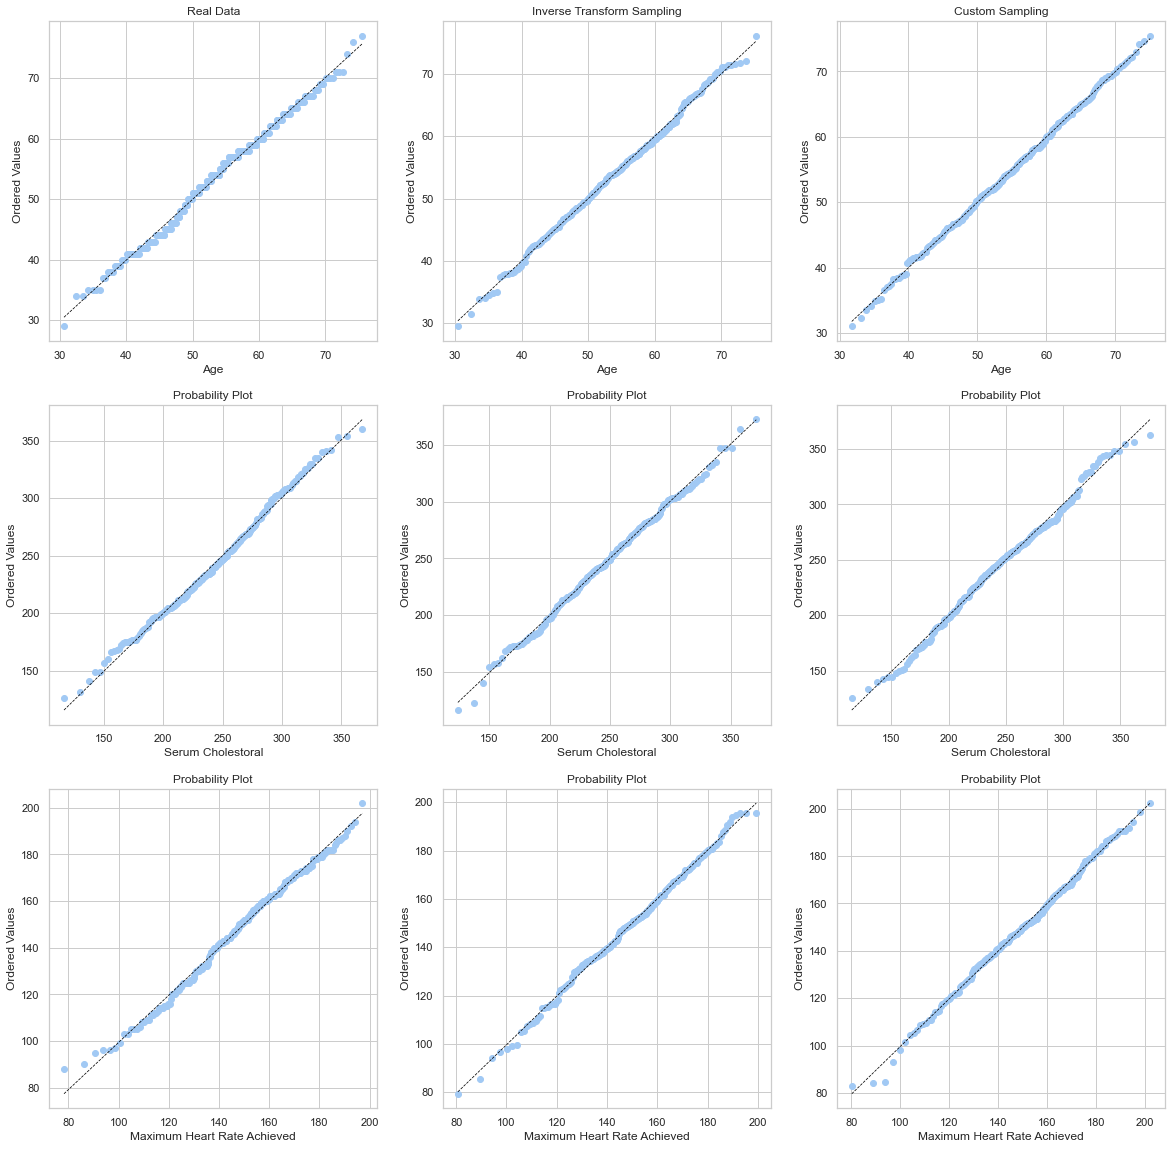

In [20]:
figure, ax = plt.subplots(3, 3, figsize=(20, 20))
sns.set_theme(style='whitegrid', palette='pastel')

return_biplot(df.age, distribution=scipy.stats.beta, ax=ax[0, 0])
return_biplot(df_its.age, distribution=scipy.stats.beta, ax=ax[0, 1])
return_biplot(df_sample.age, distribution=scipy.stats.beta, ax=ax[0, 2])

return_biplot(df.chol, distribution=scipy.stats.norm, ax=ax[1, 0])
return_biplot(df_its.chol, distribution=scipy.stats.norm, ax=ax[1, 1])
return_biplot(df_sample.chol, distribution=scipy.stats.norm, ax=ax[1, 2])

return_biplot(df.thalach, distribution=scipy.stats.beta, ax=ax[2, 0])
return_biplot(df_its.thalach, distribution=scipy.stats.beta, ax=ax[2, 1])
return_biplot(df_sample.thalach, distribution=scipy.stats.beta, ax=ax[2, 2])

ax[0, 0].set_title('Real Data')
ax[0, 1].set_title('Inverse Transform Sampling')
ax[0, 2].set_title('Custom Sampling')

ax[0, 0].set(xlabel='Age')
ax[0, 1].set(xlabel='Age')
ax[0, 2].set(xlabel='Age')
ax[1, 0].set(xlabel='Serum Cholestoral')
ax[1, 1].set(xlabel='Serum Cholestoral')
ax[1, 2].set(xlabel='Serum Cholestoral')
ax[2, 0].set(xlabel='Maximum Heart Rate Achieved')
ax[2, 1].set(xlabel='Maximum Heart Rate Achieved')
ax[2, 2].set(xlabel='Maximum Heart Rate Achieved')

plt.show()

<a name='003'></a>

<h2>3. Estimation of Relations Between Predictors and Chosen Target Variables</h2>

<a href='#000'>Back</a>

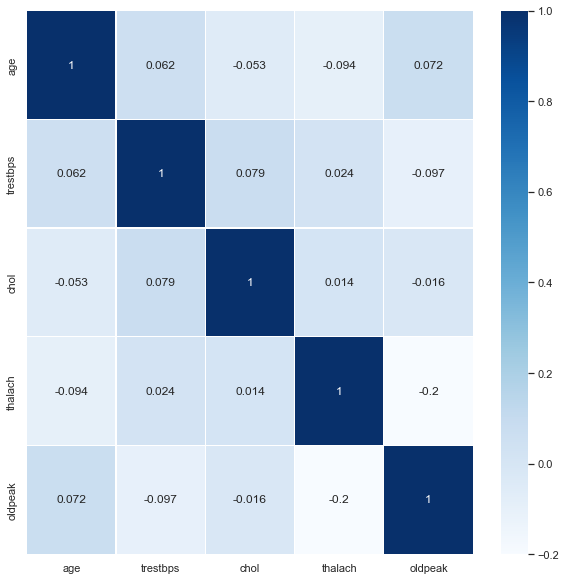

In [20]:
figure, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.set_theme(style='whitegrid', palette='pastel')

sns.heatmap(df_its[['age', 'trestbps', 'chol', 'thalach', 'oldpeak']].corr(), cmap='Blues', annot=True, linewidths=0.25)

plt.show()

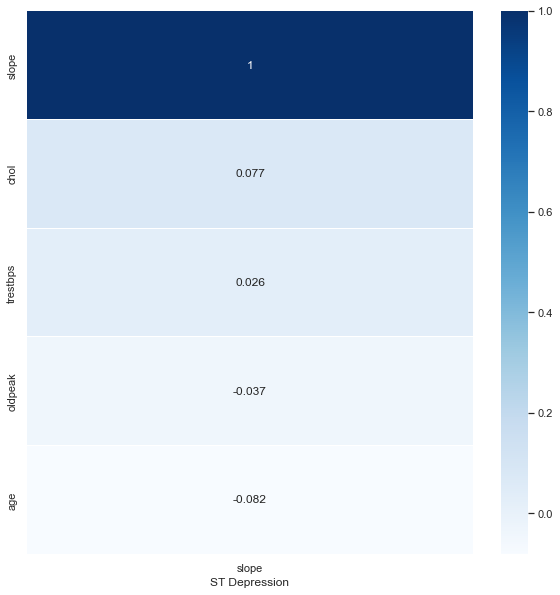

In [21]:
figure, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.set_theme(style='whitegrid', palette='pastel')

sns.heatmap(
    df_sample[['trestbps', 'slope', 'oldpeak', 'chol', 'age']].corr()[['slope']].sort_values(by='slope', ascending=False),
    cmap='Blues',
    annot=True,
    linewidths=0.25
)

ax.set(xlabel='ST Depression')
plt.show()

<a name='004'></a>

<h2>4. Bayesian Network. Part I</h2>

<a href='#000'>Back</a>

In [22]:
predictors = df_its[['age', 'oldpeak', 'cp', 'target']]
target = df_its[['slope']]

df_its.drop(['thalach'], axis=1, inplace=True)
df_its.drop(['ca'], axis=1, inplace=True)

In [23]:
df_transformed = df_its.copy()
discretizer = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='kmeans')
df_discretized = discretizer.fit_transform(df_its.values[:, [0, 1, 2, 3]])
df_transformed[['age', 'trestbps', 'chol', 'oldpeak']] = df_discretized

In [24]:
df_transformed.head(10)

,age,trestbps,chol,oldpeak,slope,target,cp
0,1.0,0.0,1.0,1.0,0,1,3
1,0.0,1.0,1.0,0.0,0,1,2
2,0.0,1.0,1.0,0.0,2,1,1
3,0.0,1.0,0.0,0.0,2,1,1
4,1.0,0.0,0.0,0.0,2,1,0
5,1.0,0.0,1.0,1.0,1,1,0
6,0.0,0.0,0.0,0.0,1,1,1
7,1.0,0.0,0.0,0.0,2,1,1
9,0.0,1.0,0.0,1.0,2,1,2
10,0.0,1.0,1.0,0.0,2,1,0


In [45]:
edges_list = [
    ('age', 'trestbps'),
    ('oldpeak', 'trestbps'),
    ('trestbps', 'slope'),
    ('target', 'trestbps'),
    ('cp', 'slope')
]

our_model = BayesianModel(edges_list)

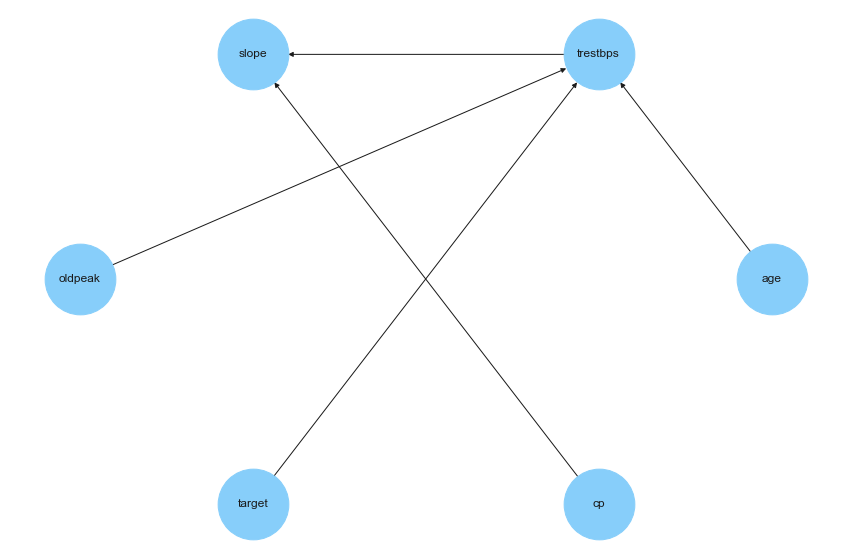

In [46]:
figure, ax = plt.subplots(1, 1, figsize=(15, 10))

graph = nx.DiGraph()
graph.add_edges_from(our_model.edges())

positions = nx.layout.circular_layout(graph)
nx.draw(graph, positions, with_labels=True, node_color='lightskyblue', node_size=5000)

plt.show()

<a name='005'></a>

<h2>5. Bayesian Network. Part II</h2>

<a href='#000'>Back</a>

Hill Climb Search.

In [27]:
hc_search = HillClimbSearch(data=df_transformed)
hc_k2 = hc_search.estimate(scoring_method=K2Score(df_transformed))
hc_bic = hc_search.estimate(scoring_method=BicScore(df_transformed))

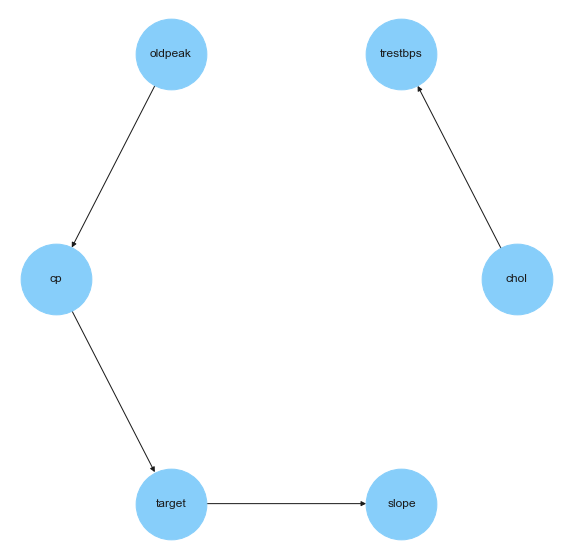

In [28]:
figure, ax = plt.subplots(1, 1, figsize=(10, 10))

graph = nx.DiGraph()
graph.add_edges_from(hc_k2.edges())
positions = nx.layout.circular_layout(graph)
nx.draw(graph, positions, with_labels=True, node_color='lightskyblue', node_size=5000)

plt.show()

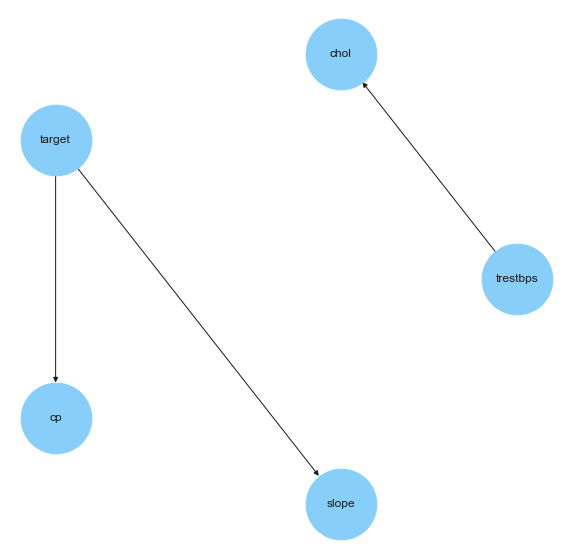

In [29]:
figure, ax = plt.subplots(1, 1, figsize=(10, 10))

graph = nx.DiGraph()
graph.add_edges_from(hc_bic.edges())
positions = nx.layout.circular_layout(graph)
nx.draw(graph, positions, with_labels=True, node_color='lightskyblue', node_size=5000)

plt.show()

Tree Search.

In [30]:
e_search = TreeSearch(data=df_transformed)
e_model = e_search.estimate()

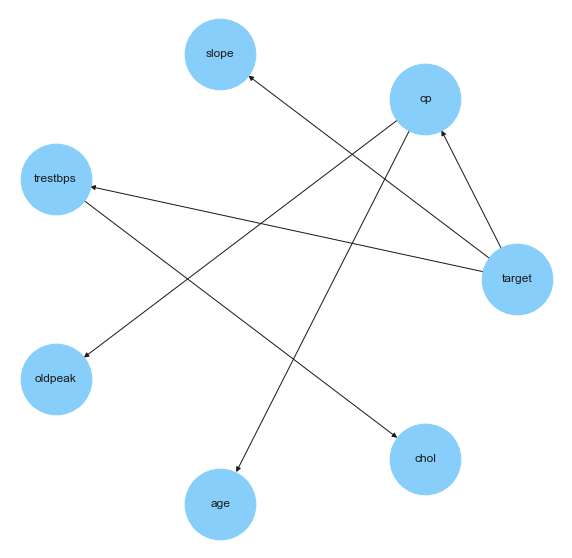

In [31]:
figure, ax = plt.subplots(1, 1, figsize=(10, 10))

graph = nx.DiGraph()
graph.add_edges_from(e_model.edges())
positions = nx.layout.circular_layout(graph)
nx.draw(graph, positions, with_labels=True, node_color='lightskyblue', node_size=5000)

plt.show()

<a name='006'></a>

<h2>6. Quality Analysis</h2>

<a href='#000'>Back</a>

In [32]:
def return_sample(model, data, size):
    model_s = BayesianModel(model.edges())
    model_s.fit(data)
    
    sampling = BayesianModelSampling(model_s)
    sample = sampling.forward_sample(size=size)
    return sample

In [33]:
sample_hc = return_sample(hc_k2, df_transformed, df_transformed.shape[0])
sample_e = return_sample(e_model, df_transformed, df_transformed.shape[0])
sample_our = return_sample(our_model, df_transformed, df_transformed.shape[0])

ST Depression Estimation.

In [34]:
print(classification_report(df_transformed.slope, sample_hc.slope))

              precision    recall  f1-score   support

           0       0.21      0.25      0.23        16
           1       0.47      0.47      0.47       130
           2       0.50      0.49      0.50       138

    accuracy                           0.47       284
   macro avg       0.39      0.40      0.40       284
weighted avg       0.47      0.47      0.47       284



In [35]:
print(classification_report(df_transformed.slope, sample_e.slope))

              precision    recall  f1-score   support

           0       0.11      0.19      0.14        16
           1       0.47      0.48      0.48       130
           2       0.50      0.46      0.48       138

    accuracy                           0.45       284
   macro avg       0.36      0.37      0.36       284
weighted avg       0.47      0.45      0.46       284



Target Estimation.

In [36]:
print(classification_report(df_transformed.target, sample_hc.target))

              precision    recall  f1-score   support

           0       0.49      0.46      0.48       125
           1       0.59      0.62      0.60       159

    accuracy                           0.55       284
   macro avg       0.54      0.54      0.54       284
weighted avg       0.55      0.55      0.55       284



In [37]:
print(classification_report(df_transformed.target, sample_e.target))

              precision    recall  f1-score   support

           0       0.39      0.41      0.40       125
           1       0.52      0.50      0.51       159

    accuracy                           0.46       284
   macro avg       0.45      0.45      0.45       284
weighted avg       0.46      0.46      0.46       284



Chest Pain Estimation.

In [38]:
print(classification_report(df_transformed.cp, sample_hc.cp))

              precision    recall  f1-score   support

           0       0.47      0.44      0.46       130
           1       0.20      0.22      0.21        49
           2       0.28      0.30      0.29        83
           3       0.05      0.05      0.05        22

    accuracy                           0.33       284
   macro avg       0.25      0.25      0.25       284
weighted avg       0.34      0.33      0.33       284



In [39]:
print(classification_report(df_transformed.cp, sample_e.cp))

              precision    recall  f1-score   support

           0       0.46      0.49      0.47       130
           1       0.10      0.10      0.10        49
           2       0.24      0.22      0.23        83
           3       0.05      0.05      0.05        22

    accuracy                           0.31       284
   macro avg       0.21      0.21      0.21       284
weighted avg       0.30      0.31      0.31       284



In [40]:
def return_histplot(target, data, sample_1, sample_2, sample_3):
    df_1 = pd.DataFrame()
    df_1[target] = data[target]
    df_1['Data'] = 'Original Data'
    df_1['Probability'] = df_1[target].apply(lambda x: (df_1.groupby(target)[target].count()[x])/data.shape[0])
    
    df_2 = pd.DataFrame()
    df_2[target] = sample_1[target]
    df_2['Data'] = 'HillClimbSearch'
    df_2['Probability'] = df_2[target].apply(lambda x: (df_2.groupby(target)[target].count()[x])/sample_1.shape[0])
    
    df_3 = pd.DataFrame()
    df_3[target] = sample_2[target]
    df_3['Data'] = 'TreeSearch'
    df_3['Probability'] = df_3[target].apply(lambda x: (df_3.groupby(target)[target].count()[x])/sample_2.shape[0])
    
    df_4 = pd.DataFrame()
    df_4[target] = sample_3[target]
    df_4['Data'] = 'Our Structure'
    df_4['Probability'] = df_4[target].apply(lambda x: (df_4.groupby(target)[target].count()[x])/sample_3.shape[0])
    
    df = pd.DataFrame()
    df = pd.concat([df_1, df_2, df_3, df_4])
    
    figure, ax = plt.subplots(1, 1, figsize=(10, 10))
    sns.set_theme(style='whitegrid', palette='pastel')
    
    sns.barplot(x=target, y='Probability', hue='Data', data=df, palette='Blues')
    
    plt.legend()
    plt.show()

Quality analysis for slope of the peak exercise ST segment.

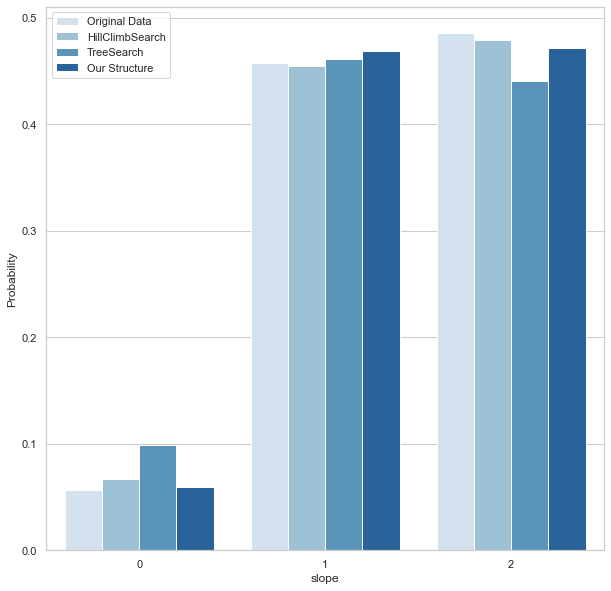

In [41]:
return_histplot(
    'slope',
    df_transformed,
    sample_hc,
    sample_e,
    sample_our
)

Quality analysis for risk of heart disease.

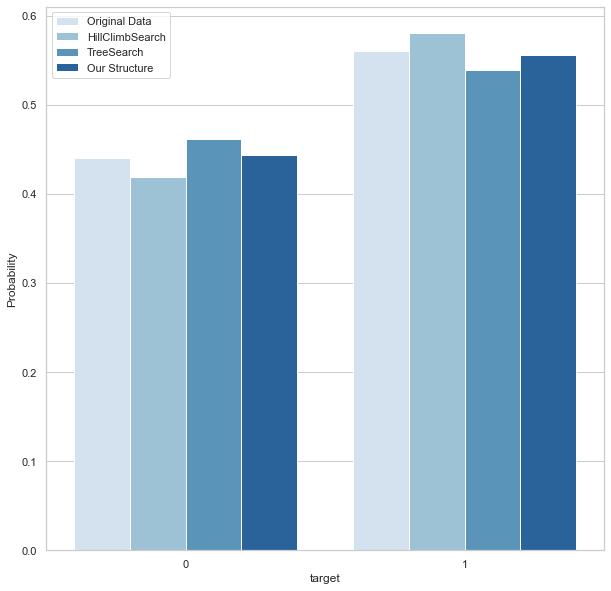

In [42]:
return_histplot(
    'target',
    df_transformed,
    sample_hc,
    sample_e,
    sample_our
)

Quality analysis for chest pain type.

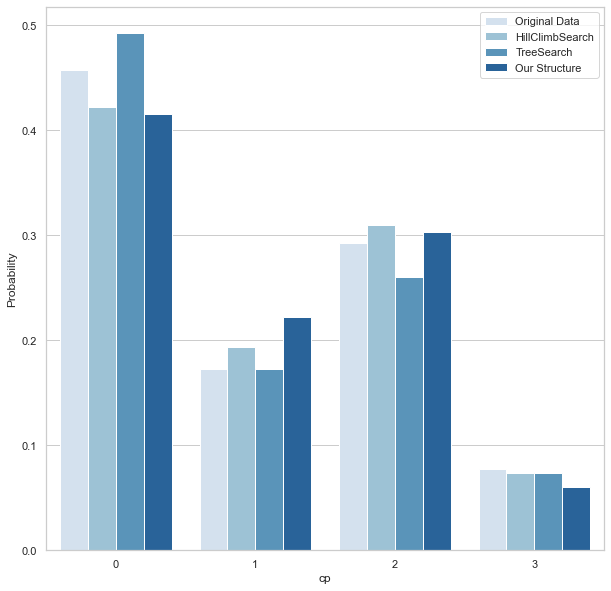

In [43]:
return_histplot(
    'cp',
    df_transformed,
    sample_hc,
    sample_e,
    sample_our
)